# Import Libraries

In [1]:
import datetime
print("Model execution started at:" + datetime.datetime.today().ctime())

Model execution started at:Sun Mar 29 08:48:45 2020


In [2]:
import src
import src.dataset.dataset as dst
import src.dataset.dataloader as dl
import src.preprocessing.albumentationstransforms as preprocessing
import src.utils.utils as utils
import src.train.train_model as train
import src.visualization.plotdata as plotdata
import src.preprocessing.customcompose as customcompose
from src.train.lrfinder.lrfinder import LRFinder


%config IPCompleter.greedy=True

%reload_ext autoreload


In [3]:
%autoreload 2  # Autoreload all modules

In [4]:
def printgpuinfo():
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
      print('and then re-execute this cell.')
    else:
      print(gpu_info)

In [5]:
def showsysteminfo():
    from psutil import virtual_memory
    ram_gb = virtual_memory().total / 1e9
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

    if ram_gb < 20:
      print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
      print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
      print('re-execute this cell.')
    else:
      print('You are using a high-RAM runtime!')

In [6]:
import torch
print(torch.__version__)

1.4.0


In [7]:
# mean,std= utils.Utils.calculatemeanandstddeviation()
# print("mean: " + str(mean))
# print("std: " + str(std))
mean=[0.5,0.5,0.5]
std=[0.5,0.5,0.5]
preproc = preprocessing.AlbumentaionsTransforms()
train_transforms = preproc.gettraintransforms(mean,std)
test_transforms = preproc.gettesttransforms(mean,std)
compose_train = customcompose.CustomCompose(train_transforms)
compose_test = customcompose.CustomCompose(test_transforms)

In [8]:
ds = dst.Dataset()
train_dataset = ds.gettraindataset(compose_train)
test_dataset = ds.gettestdataset(compose_test)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
batch_size = 128
dataloader = dl.Cifar10Dataloader(traindataset=train_dataset, testdataset=test_dataset,batch_size=batch_size)
train_loader = dataloader.gettraindataloader()
test_loader = dataloader.gettestdataloader()

CUDA Available? True
128


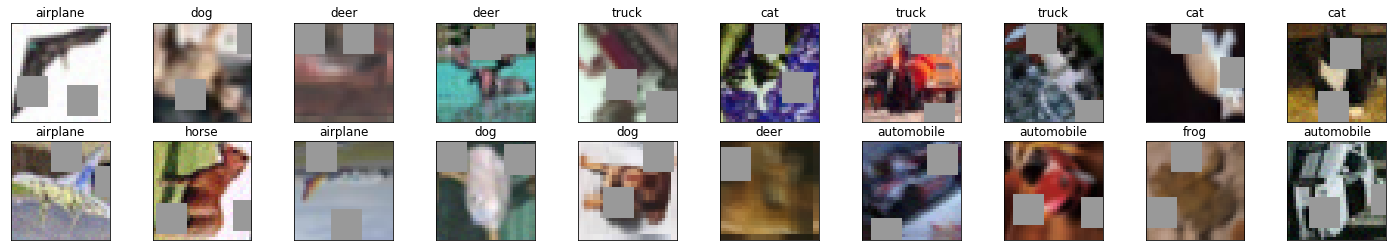

In [10]:
# specify the image classes
classes = ds.getclassesinCIFAR10dataset()

#TODO show transformed images fom dataset
dataiterator = iter(train_loader)
plotdata.PlotData.showImagesfromdataset(dataiterator,classes=classes)

In [11]:
cnn_model, device = utils.Utils.createmodelresnet18()
train_model = train.TrainModel()
train_model.showmodelsummary(cnn_model)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [12]:
optimizer = utils.Utils.createoptimizer(cnn_model, lr=0.08, momentum=0.9, weight_decay=0, nesterov=True)
criterion = torch.nn.CrossEntropyLoss()


Learning rate search finished. See the graph with {finder_name}.plot()


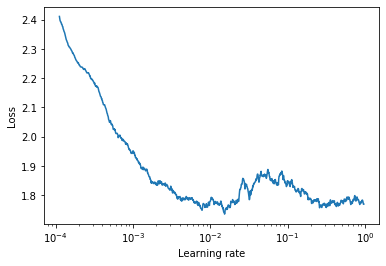

In [13]:
lr_finder = LRFinder(cnn_model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, start_lr=0.0001,end_lr=1, num_iter=1000, step_mode="exp")
lr_finder.plot()

In [14]:
lr_finder.reset()

In [15]:
lr_finder.range_test(train_loader, val_loader=test_loader, start_lr=0.0001,end_lr=1, num_iter=200, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


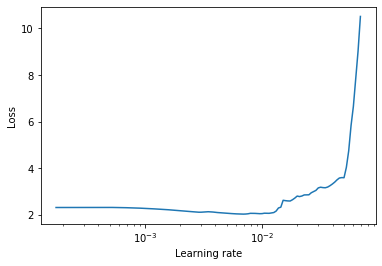

In [16]:
lr_finder.plot(skip_end=0)

In [17]:
lr_finder.reset()

In [18]:
optimizer = utils.Utils.createoptimizer(cnn_model, lr=0.08, momentum=0.9, weight_decay=0, nesterov=True)
scheduler = utils.Utils.createscheduler(optimizer, mode='max', factor=0.9, patience=2,
                                        verbose=True)

In [19]:
lr_data = []
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
epochs = 100
for epoch in range(1, epochs+1):
    print("EPOCH:", epoch)
    train_model.train(cnn_model, device, train_loader, optimizer, 1)
    t_acc_epoch = train_model.test(model=cnn_model, device=device, test_loader=test_loader, class_correct=class_correct,
                                   class_total=class_total, epoch=epoch, lr_data=lr_data)
    scheduler.step(t_acc_epoch)
    for param_groups in optimizer.param_groups:
        print("Learning rate =", param_groups['lr'], " for epoch: ", epoch + 1)  # print LR for different epochs
        lr_data.append(param_groups['lr'])

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


/home/abhijit/.virtualenvs/dl4cv/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=1.600854516029358 Batch_id=390 Accuracy=28.07: 100%|██████████| 391/391 [02:30<00:00,  2.59it/s] 



Test set: Average loss: 0.0129, Accuracy: 4072/10000 (40.72%)

Validation accuracy increased (0.000000 --> 40.720000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  2
EPOCH: 2


Loss=1.502982258796692 Batch_id=390 Accuracy=37.32: 100%|██████████| 391/391 [02:32<00:00,  2.56it/s] 



Test set: Average loss: 0.0124, Accuracy: 4219/10000 (42.19%)

Validation accuracy increased (40.720000 --> 42.190000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  3
EPOCH: 3


Loss=1.5861165523529053 Batch_id=390 Accuracy=41.71: 100%|██████████| 391/391 [02:32<00:00,  2.57it/s]



Test set: Average loss: 0.0109, Accuracy: 4970/10000 (49.70%)

Validation accuracy increased (42.190000 --> 49.700000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  4
EPOCH: 4


Loss=1.39765202999115 Batch_id=390 Accuracy=45.25: 100%|██████████| 391/391 [02:40<00:00,  2.44it/s]  



Test set: Average loss: 0.0099, Accuracy: 5471/10000 (54.71%)

Validation accuracy increased (49.700000 --> 54.710000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  5
EPOCH: 5


Loss=1.4208794832229614 Batch_id=390 Accuracy=48.42: 100%|██████████| 391/391 [02:41<00:00,  2.43it/s]



Test set: Average loss: 0.0089, Accuracy: 6004/10000 (60.04%)

Validation accuracy increased (54.710000 --> 60.040000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  6
EPOCH: 6


Loss=1.3132286071777344 Batch_id=390 Accuracy=50.82: 100%|██████████| 391/391 [02:41<00:00,  2.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0087, Accuracy: 5979/10000 (59.79%)

Learning rate = 0.08  for epoch:  7
EPOCH: 7


Loss=1.417517900466919 Batch_id=390 Accuracy=53.53: 100%|██████████| 391/391 [02:46<00:00,  2.35it/s] 



Test set: Average loss: 0.0083, Accuracy: 6279/10000 (62.79%)

Validation accuracy increased (60.040000 --> 62.790000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  8
EPOCH: 8


Loss=1.4765175580978394 Batch_id=390 Accuracy=55.59: 100%|██████████| 391/391 [02:47<00:00,  2.34it/s]



Test set: Average loss: 0.0081, Accuracy: 6384/10000 (63.84%)

Validation accuracy increased (62.790000 --> 63.840000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  9
EPOCH: 9


Loss=1.0831164121627808 Batch_id=390 Accuracy=57.10: 100%|██████████| 391/391 [02:53<00:00,  2.26it/s]



Test set: Average loss: 0.0076, Accuracy: 6514/10000 (65.14%)

Validation accuracy increased (63.840000 --> 65.140000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  10
EPOCH: 10


Loss=1.0451089143753052 Batch_id=390 Accuracy=58.88: 100%|██████████| 391/391 [02:49<00:00,  2.30it/s]



Test set: Average loss: 0.0072, Accuracy: 6812/10000 (68.12%)

Validation accuracy increased (65.140000 --> 68.120000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  11
EPOCH: 11


Loss=1.2173775434494019 Batch_id=390 Accuracy=60.52: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s]



Test set: Average loss: 0.0064, Accuracy: 7153/10000 (71.53%)

Validation accuracy increased (68.120000 --> 71.530000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  12
EPOCH: 12


Loss=0.8683527112007141 Batch_id=390 Accuracy=62.22: 100%|██████████| 391/391 [02:46<00:00,  2.35it/s]



Test set: Average loss: 0.0061, Accuracy: 7263/10000 (72.63%)

Validation accuracy increased (71.530000 --> 72.630000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  13
EPOCH: 13


Loss=0.9569063186645508 Batch_id=390 Accuracy=63.67: 100%|██████████| 391/391 [02:40<00:00,  2.44it/s]



Test set: Average loss: 0.0057, Accuracy: 7501/10000 (75.01%)

Validation accuracy increased (72.630000 --> 75.010000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  14
EPOCH: 14


Loss=1.0037592649459839 Batch_id=390 Accuracy=64.72: 100%|██████████| 391/391 [02:43<00:00,  2.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 7448/10000 (74.48%)

Learning rate = 0.08  for epoch:  15
EPOCH: 15


Loss=1.071603536605835 Batch_id=390 Accuracy=65.98: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s] 



Test set: Average loss: 0.0057, Accuracy: 7531/10000 (75.31%)

Validation accuracy increased (75.010000 --> 75.310000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  16
EPOCH: 16


Loss=0.9666067361831665 Batch_id=390 Accuracy=66.25: 100%|██████████| 391/391 [02:39<00:00,  2.46it/s]



Test set: Average loss: 0.0053, Accuracy: 7696/10000 (76.96%)

Validation accuracy increased (75.310000 --> 76.960000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  17
EPOCH: 17


Loss=0.8323134183883667 Batch_id=390 Accuracy=67.48: 100%|██████████| 391/391 [02:47<00:00,  2.34it/s]



Test set: Average loss: 0.0053, Accuracy: 7737/10000 (77.37%)

Validation accuracy increased (76.960000 --> 77.370000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  18
EPOCH: 18


Loss=0.9366215467453003 Batch_id=390 Accuracy=68.14: 100%|██████████| 391/391 [02:41<00:00,  2.42it/s]



Test set: Average loss: 0.0047, Accuracy: 7943/10000 (79.43%)

Validation accuracy increased (77.370000 --> 79.430000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  19
EPOCH: 19


Loss=1.062079906463623 Batch_id=390 Accuracy=68.93: 100%|██████████| 391/391 [02:42<00:00,  2.41it/s] 



Test set: Average loss: 0.0046, Accuracy: 8032/10000 (80.32%)

Validation accuracy increased (79.430000 --> 80.320000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  20
EPOCH: 20


Loss=0.946673572063446 Batch_id=390 Accuracy=69.70: 100%|██████████| 391/391 [02:47<00:00,  2.33it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 7834/10000 (78.34%)

Learning rate = 0.08  for epoch:  21
EPOCH: 21


Loss=0.7621275782585144 Batch_id=390 Accuracy=70.77: 100%|██████████| 391/391 [02:45<00:00,  2.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8017/10000 (80.17%)

Learning rate = 0.08  for epoch:  22
EPOCH: 22


Loss=0.828415036201477 Batch_id=390 Accuracy=71.16: 100%|██████████| 391/391 [02:43<00:00,  2.39it/s] 



Test set: Average loss: 0.0044, Accuracy: 8118/10000 (81.18%)

Validation accuracy increased (80.320000 --> 81.180000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  23
EPOCH: 23


Loss=0.921278178691864 Batch_id=390 Accuracy=71.58: 100%|██████████| 391/391 [02:48<00:00,  2.31it/s] 



Test set: Average loss: 0.0040, Accuracy: 8284/10000 (82.84%)

Validation accuracy increased (81.180000 --> 82.840000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.08  for epoch:  24
EPOCH: 24


Loss=0.739940345287323 Batch_id=390 Accuracy=71.65: 100%|██████████| 391/391 [02:46<00:00,  2.35it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8109/10000 (81.09%)

Learning rate = 0.08  for epoch:  25
EPOCH: 25


Loss=0.6848235726356506 Batch_id=390 Accuracy=72.15: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8164/10000 (81.64%)

Learning rate = 0.08  for epoch:  26
EPOCH: 26


Loss=1.1111754179000854 Batch_id=390 Accuracy=73.05: 100%|██████████| 391/391 [02:53<00:00,  2.26it/s]



Test set: Average loss: 0.0039, Accuracy: 8329/10000 (83.29%)

Validation accuracy increased (82.840000 --> 83.290000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    26: reducing learning rate of group 0 to 7.2000e-02.
Learning rate = 0.07200000000000001  for epoch:  27
EPOCH: 27


Loss=0.6465264558792114 Batch_id=390 Accuracy=73.84: 100%|██████████| 391/391 [03:00<00:00,  2.17it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8281/10000 (82.81%)

Learning rate = 0.07200000000000001  for epoch:  28
EPOCH: 28


Loss=0.8731602430343628 Batch_id=390 Accuracy=74.44: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]



Test set: Average loss: 0.0039, Accuracy: 8330/10000 (83.30%)

Validation accuracy increased (83.290000 --> 83.300000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.07200000000000001  for epoch:  29
EPOCH: 29


Loss=0.7478398084640503 Batch_id=390 Accuracy=74.82: 100%|██████████| 391/391 [03:29<00:00,  1.87it/s] 



Test set: Average loss: 0.0036, Accuracy: 8484/10000 (84.84%)

Validation accuracy increased (83.300000 --> 84.840000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.07200000000000001  for epoch:  30
EPOCH: 30


Loss=0.682634711265564 Batch_id=390 Accuracy=75.25: 100%|██████████| 391/391 [03:28<00:00,  1.87it/s]  



Test set: Average loss: 0.0036, Accuracy: 8484/10000 (84.84%)

Validation accuracy increased (84.840000 --> 84.840000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.07200000000000001  for epoch:  31
EPOCH: 31


Loss=0.6063271760940552 Batch_id=390 Accuracy=75.69: 100%|██████████| 391/391 [03:28<00:00,  1.88it/s] 



Test set: Average loss: 0.0036, Accuracy: 8498/10000 (84.98%)

Validation accuracy increased (84.840000 --> 84.980000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.07200000000000001  for epoch:  32
EPOCH: 32


Loss=0.6549846529960632 Batch_id=390 Accuracy=75.74: 100%|██████████| 391/391 [02:57<00:00,  2.21it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8466/10000 (84.66%)

Epoch    32: reducing learning rate of group 0 to 6.4800e-02.
Learning rate = 0.06480000000000001  for epoch:  33
EPOCH: 33


Loss=0.8333436250686646 Batch_id=390 Accuracy=76.73: 100%|██████████| 391/391 [02:56<00:00,  2.21it/s] 



Test set: Average loss: 0.0035, Accuracy: 8538/10000 (85.38%)

Validation accuracy increased (84.980000 --> 85.380000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.06480000000000001  for epoch:  34
EPOCH: 34


Loss=0.8286186456680298 Batch_id=390 Accuracy=77.31: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8522/10000 (85.22%)

Learning rate = 0.06480000000000001  for epoch:  35
EPOCH: 35


Loss=0.7000148892402649 Batch_id=390 Accuracy=77.61: 100%|██████████| 391/391 [02:51<00:00,  2.29it/s] 



Test set: Average loss: 0.0033, Accuracy: 8622/10000 (86.22%)

Validation accuracy increased (85.380000 --> 86.220000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.06480000000000001  for epoch:  36
EPOCH: 36


Loss=0.5795215964317322 Batch_id=390 Accuracy=77.71: 100%|██████████| 391/391 [02:42<00:00,  2.40it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8618/10000 (86.18%)

Learning rate = 0.06480000000000001  for epoch:  37
EPOCH: 37


Loss=0.68492591381073 Batch_id=390 Accuracy=77.90: 100%|██████████| 391/391 [02:44<00:00,  2.38it/s]   
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8550/10000 (85.50%)

Learning rate = 0.06480000000000001  for epoch:  38
EPOCH: 38


Loss=0.7231035232543945 Batch_id=390 Accuracy=78.40: 100%|██████████| 391/391 [02:49<00:00,  2.30it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8595/10000 (85.95%)

Epoch    38: reducing learning rate of group 0 to 5.8320e-02.
Learning rate = 0.05832000000000001  for epoch:  39
EPOCH: 39


Loss=0.5620312094688416 Batch_id=390 Accuracy=78.80: 100%|██████████| 391/391 [02:46<00:00,  2.35it/s] 



Test set: Average loss: 0.0032, Accuracy: 8695/10000 (86.95%)

Validation accuracy increased (86.220000 --> 86.950000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.05832000000000001  for epoch:  40
EPOCH: 40


Loss=0.7682273387908936 Batch_id=390 Accuracy=79.28: 100%|██████████| 391/391 [02:42<00:00,  2.41it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8667/10000 (86.67%)

Learning rate = 0.05832000000000001  for epoch:  41
EPOCH: 41


Loss=0.6107792854309082 Batch_id=390 Accuracy=79.47: 100%|██████████| 391/391 [02:40<00:00,  2.43it/s] 



Test set: Average loss: 0.0031, Accuracy: 8699/10000 (86.99%)

Validation accuracy increased (86.950000 --> 86.990000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    41: reducing learning rate of group 0 to 5.2488e-02.
Learning rate = 0.052488000000000014  for epoch:  42
EPOCH: 42


Loss=0.4016498923301697 Batch_id=390 Accuracy=79.88: 100%|██████████| 391/391 [02:41<00:00,  2.42it/s] 



Test set: Average loss: 0.0030, Accuracy: 8730/10000 (87.30%)

Validation accuracy increased (86.990000 --> 87.300000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.052488000000000014  for epoch:  43
EPOCH: 43


Loss=0.6796613931655884 Batch_id=390 Accuracy=80.22: 100%|██████████| 391/391 [02:35<00:00,  2.51it/s] 



Test set: Average loss: 0.0029, Accuracy: 8764/10000 (87.64%)

Validation accuracy increased (87.300000 --> 87.640000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.052488000000000014  for epoch:  44
EPOCH: 44


Loss=0.6574798226356506 Batch_id=390 Accuracy=80.44: 100%|██████████| 391/391 [02:44<00:00,  2.38it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8730/10000 (87.30%)

Learning rate = 0.052488000000000014  for epoch:  45
EPOCH: 45


Loss=0.6137663125991821 Batch_id=390 Accuracy=80.60: 100%|██████████| 391/391 [02:40<00:00,  2.44it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8693/10000 (86.93%)

Epoch    45: reducing learning rate of group 0 to 4.7239e-02.
Learning rate = 0.047239200000000016  for epoch:  46
EPOCH: 46


Loss=0.46976637840270996 Batch_id=390 Accuracy=81.43: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s]



Test set: Average loss: 0.0029, Accuracy: 8794/10000 (87.94%)

Validation accuracy increased (87.640000 --> 87.940000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.047239200000000016  for epoch:  47
EPOCH: 47


Loss=0.5531087517738342 Batch_id=390 Accuracy=81.50: 100%|██████████| 391/391 [02:46<00:00,  2.35it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8766/10000 (87.66%)

Learning rate = 0.047239200000000016  for epoch:  48
EPOCH: 48


Loss=0.4900170862674713 Batch_id=390 Accuracy=81.33: 100%|██████████| 391/391 [02:46<00:00,  2.35it/s] 



Test set: Average loss: 0.0028, Accuracy: 8825/10000 (88.25%)

Validation accuracy increased (87.940000 --> 88.250000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.047239200000000016  for epoch:  49
EPOCH: 49


Loss=0.6143115758895874 Batch_id=390 Accuracy=81.98: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8822/10000 (88.22%)

Learning rate = 0.047239200000000016  for epoch:  50
EPOCH: 50


Loss=0.5660229921340942 Batch_id=390 Accuracy=81.83: 100%|██████████| 391/391 [02:42<00:00,  2.41it/s] 



Test set: Average loss: 0.0028, Accuracy: 8832/10000 (88.32%)

Validation accuracy increased (88.250000 --> 88.320000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.047239200000000016  for epoch:  51
EPOCH: 51


Loss=0.5195585489273071 Batch_id=390 Accuracy=82.23: 100%|██████████| 391/391 [02:42<00:00,  2.41it/s] 



Test set: Average loss: 0.0028, Accuracy: 8847/10000 (88.47%)

Validation accuracy increased (88.320000 --> 88.470000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    51: reducing learning rate of group 0 to 4.2515e-02.
Learning rate = 0.042515280000000016  for epoch:  52
EPOCH: 52


Loss=0.6970103979110718 Batch_id=390 Accuracy=82.06: 100%|██████████| 391/391 [02:45<00:00,  2.37it/s] 



Test set: Average loss: 0.0026, Accuracy: 8867/10000 (88.67%)

Validation accuracy increased (88.470000 --> 88.670000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.042515280000000016  for epoch:  53
EPOCH: 53


Loss=0.5435354709625244 Batch_id=390 Accuracy=82.48: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8841/10000 (88.41%)

Learning rate = 0.042515280000000016  for epoch:  54
EPOCH: 54


Loss=0.4696374535560608 Batch_id=390 Accuracy=83.02: 100%|██████████| 391/391 [03:02<00:00,  2.14it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8849/10000 (88.49%)

Epoch    54: reducing learning rate of group 0 to 3.8264e-02.
Learning rate = 0.03826375200000002  for epoch:  55
EPOCH: 55


Loss=0.4167042672634125 Batch_id=390 Accuracy=83.16: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s] 



Test set: Average loss: 0.0028, Accuracy: 8872/10000 (88.72%)

Validation accuracy increased (88.670000 --> 88.720000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.03826375200000002  for epoch:  56
EPOCH: 56


Loss=0.3725946247577667 Batch_id=390 Accuracy=83.28: 100%|██████████| 391/391 [02:50<00:00,  2.29it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8866/10000 (88.66%)

Learning rate = 0.03826375200000002  for epoch:  57
EPOCH: 57


Loss=0.6421681642532349 Batch_id=390 Accuracy=83.63: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8824/10000 (88.24%)

Epoch    57: reducing learning rate of group 0 to 3.4437e-02.
Learning rate = 0.034437376800000016  for epoch:  58
EPOCH: 58


Loss=0.46777382493019104 Batch_id=390 Accuracy=84.03: 100%|██████████| 391/391 [02:47<00:00,  2.33it/s]



Test set: Average loss: 0.0027, Accuracy: 8896/10000 (88.96%)

Validation accuracy increased (88.720000 --> 88.960000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.034437376800000016  for epoch:  59
EPOCH: 59


Loss=0.4380057752132416 Batch_id=390 Accuracy=84.05: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8887/10000 (88.87%)

Learning rate = 0.034437376800000016  for epoch:  60
EPOCH: 60


Loss=0.6948054432868958 Batch_id=390 Accuracy=84.23: 100%|██████████| 391/391 [02:46<00:00,  2.34it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8895/10000 (88.95%)

Epoch    60: reducing learning rate of group 0 to 3.0994e-02.
Learning rate = 0.030993639120000017  for epoch:  61
EPOCH: 61


Loss=0.39777955412864685 Batch_id=390 Accuracy=84.72: 100%|██████████| 391/391 [02:49<00:00,  2.30it/s]



Test set: Average loss: 0.0028, Accuracy: 8911/10000 (89.11%)

Validation accuracy increased (88.960000 --> 89.110000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.030993639120000017  for epoch:  62
EPOCH: 62


Loss=0.43191686272621155 Batch_id=390 Accuracy=84.79: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8887/10000 (88.87%)

Learning rate = 0.030993639120000017  for epoch:  63
EPOCH: 63


Loss=0.5145968198776245 Batch_id=390 Accuracy=84.87: 100%|██████████| 391/391 [02:50<00:00,  2.29it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8904/10000 (89.04%)

Epoch    63: reducing learning rate of group 0 to 2.7894e-02.
Learning rate = 0.027894275208000016  for epoch:  64
EPOCH: 64


Loss=0.6052696704864502 Batch_id=390 Accuracy=85.26: 100%|██████████| 391/391 [02:54<00:00,  2.25it/s] 



Test set: Average loss: 0.0026, Accuracy: 8962/10000 (89.62%)

Validation accuracy increased (89.110000 --> 89.620000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.027894275208000016  for epoch:  65
EPOCH: 65


Loss=0.5260249376296997 Batch_id=390 Accuracy=85.34: 100%|██████████| 391/391 [02:49<00:00,  2.30it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8958/10000 (89.58%)

Learning rate = 0.027894275208000016  for epoch:  66
EPOCH: 66


Loss=0.45034223794937134 Batch_id=390 Accuracy=85.36: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8946/10000 (89.46%)

Learning rate = 0.027894275208000016  for epoch:  67
EPOCH: 67


Loss=0.36019378900527954 Batch_id=390 Accuracy=85.59: 100%|██████████| 391/391 [03:07<00:00,  2.09it/s]



Test set: Average loss: 0.0026, Accuracy: 8984/10000 (89.84%)

Validation accuracy increased (89.620000 --> 89.840000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    67: reducing learning rate of group 0 to 2.5105e-02.
Learning rate = 0.025104847687200015  for epoch:  68
EPOCH: 68


Loss=0.22054624557495117 Batch_id=390 Accuracy=86.08: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8962/10000 (89.62%)

Learning rate = 0.025104847687200015  for epoch:  69
EPOCH: 69


Loss=0.45324578881263733 Batch_id=390 Accuracy=86.10: 100%|██████████| 391/391 [02:50<00:00,  2.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8972/10000 (89.72%)

Learning rate = 0.025104847687200015  for epoch:  70
EPOCH: 70


Loss=0.6068888902664185 Batch_id=390 Accuracy=86.13: 100%|██████████| 391/391 [02:41<00:00,  2.42it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8973/10000 (89.73%)

Epoch    70: reducing learning rate of group 0 to 2.2594e-02.
Learning rate = 0.022594362918480014  for epoch:  71
EPOCH: 71


Loss=0.46873268485069275 Batch_id=390 Accuracy=86.43: 100%|██████████| 391/391 [02:49<00:00,  2.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8983/10000 (89.83%)

Learning rate = 0.022594362918480014  for epoch:  72
EPOCH: 72


Loss=0.3599148690700531 Batch_id=390 Accuracy=86.38: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8951/10000 (89.51%)

Learning rate = 0.022594362918480014  for epoch:  73
EPOCH: 73


Loss=0.5812981128692627 Batch_id=390 Accuracy=86.60: 100%|██████████| 391/391 [02:45<00:00,  2.36it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8978/10000 (89.78%)

Epoch    73: reducing learning rate of group 0 to 2.0335e-02.
Learning rate = 0.020334926626632013  for epoch:  74
EPOCH: 74


Loss=0.39691591262817383 Batch_id=390 Accuracy=87.03: 100%|██████████| 391/391 [02:47<00:00,  2.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8978/10000 (89.78%)

Learning rate = 0.020334926626632013  for epoch:  75
EPOCH: 75


Loss=0.25638920068740845 Batch_id=390 Accuracy=86.87: 100%|██████████| 391/391 [02:58<00:00,  2.19it/s]



Test set: Average loss: 0.0025, Accuracy: 9031/10000 (90.31%)

Validation accuracy increased (89.840000 --> 90.310000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.020334926626632013  for epoch:  76
EPOCH: 76


Loss=0.3223569989204407 Batch_id=390 Accuracy=87.00: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9007/10000 (90.07%)

Epoch    76: reducing learning rate of group 0 to 1.8301e-02.
Learning rate = 0.018301433963968813  for epoch:  77
EPOCH: 77


Loss=0.37300437688827515 Batch_id=390 Accuracy=87.29: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8984/10000 (89.84%)

Learning rate = 0.018301433963968813  for epoch:  78
EPOCH: 78


Loss=0.30141252279281616 Batch_id=390 Accuracy=87.16: 100%|██████████| 391/391 [03:04<00:00,  2.12it/s]



Test set: Average loss: 0.0026, Accuracy: 9031/10000 (90.31%)

Validation accuracy increased (90.310000 --> 90.310000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.018301433963968813  for epoch:  79
EPOCH: 79


Loss=0.3436530828475952 Batch_id=390 Accuracy=87.42: 100%|██████████| 391/391 [03:00<00:00,  2.17it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9011/10000 (90.11%)

Epoch    79: reducing learning rate of group 0 to 1.6471e-02.
Learning rate = 0.016471290567571933  for epoch:  80
EPOCH: 80


Loss=0.3142610490322113 Batch_id=390 Accuracy=87.85: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9001/10000 (90.01%)

Learning rate = 0.016471290567571933  for epoch:  81
EPOCH: 81


Loss=0.36236047744750977 Batch_id=390 Accuracy=87.98: 100%|██████████| 391/391 [03:09<00:00,  2.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9030/10000 (90.30%)

Learning rate = 0.016471290567571933  for epoch:  82
EPOCH: 82


Loss=0.4246441721916199 Batch_id=390 Accuracy=87.94: 100%|██████████| 391/391 [03:02<00:00,  2.14it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 9015/10000 (90.15%)

Epoch    82: reducing learning rate of group 0 to 1.4824e-02.
Learning rate = 0.01482416151081474  for epoch:  83
EPOCH: 83


Loss=0.2354927957057953 Batch_id=390 Accuracy=87.94: 100%|██████████| 391/391 [03:03<00:00,  2.13it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9027/10000 (90.27%)

Learning rate = 0.01482416151081474  for epoch:  84
EPOCH: 84


Loss=0.3476770520210266 Batch_id=390 Accuracy=88.22: 100%|██████████| 391/391 [03:00<00:00,  2.16it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9029/10000 (90.29%)

Learning rate = 0.01482416151081474  for epoch:  85
EPOCH: 85


Loss=0.25582456588745117 Batch_id=390 Accuracy=88.16: 100%|██████████| 391/391 [03:05<00:00,  2.11it/s]



Test set: Average loss: 0.0025, Accuracy: 9039/10000 (90.39%)

Validation accuracy increased (90.310000 --> 90.390000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    85: reducing learning rate of group 0 to 1.3342e-02.
Learning rate = 0.013341745359733266  for epoch:  86
EPOCH: 86


Loss=0.2658885419368744 Batch_id=390 Accuracy=88.59: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s] 



Test set: Average loss: 0.0026, Accuracy: 9053/10000 (90.53%)

Validation accuracy increased (90.390000 --> 90.530000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.013341745359733266  for epoch:  87
EPOCH: 87


Loss=0.32453224062919617 Batch_id=390 Accuracy=88.55: 100%|██████████| 391/391 [03:03<00:00,  2.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9031/10000 (90.31%)

Learning rate = 0.013341745359733266  for epoch:  88
EPOCH: 88


Loss=0.3244689404964447 Batch_id=390 Accuracy=88.86: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9036/10000 (90.36%)

Learning rate = 0.013341745359733266  for epoch:  89
EPOCH: 89


Loss=0.30674850940704346 Batch_id=390 Accuracy=88.63: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]



Test set: Average loss: 0.0025, Accuracy: 9059/10000 (90.59%)

Validation accuracy increased (90.530000 --> 90.590000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    89: reducing learning rate of group 0 to 1.2008e-02.
Learning rate = 0.012007570823759939  for epoch:  90
EPOCH: 90


Loss=0.2626279592514038 Batch_id=390 Accuracy=88.90: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 9003/10000 (90.03%)

Learning rate = 0.012007570823759939  for epoch:  91
EPOCH: 91


Loss=0.4736977517604828 Batch_id=390 Accuracy=88.85: 100%|██████████| 391/391 [02:53<00:00,  2.26it/s] 



Test set: Average loss: 0.0025, Accuracy: 9061/10000 (90.61%)

Validation accuracy increased (90.590000 --> 90.610000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.012007570823759939  for epoch:  92
EPOCH: 92


Loss=0.26132482290267944 Batch_id=390 Accuracy=89.23: 100%|██████████| 391/391 [02:44<00:00,  2.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 9048/10000 (90.48%)

Epoch    92: reducing learning rate of group 0 to 1.0807e-02.
Learning rate = 0.010806813741383946  for epoch:  93
EPOCH: 93


Loss=0.4531460702419281 Batch_id=390 Accuracy=89.04: 100%|██████████| 391/391 [02:45<00:00,  2.36it/s] 



Test set: Average loss: 0.0025, Accuracy: 9068/10000 (90.68%)

Validation accuracy increased (90.610000 --> 90.680000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.010806813741383946  for epoch:  94
EPOCH: 94


Loss=0.3637882471084595 Batch_id=390 Accuracy=89.20: 100%|██████████| 391/391 [02:44<00:00,  2.37it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9039/10000 (90.39%)

Learning rate = 0.010806813741383946  for epoch:  95
EPOCH: 95


Loss=0.3508623540401459 Batch_id=390 Accuracy=89.22: 100%|██████████| 391/391 [02:46<00:00,  2.35it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9040/10000 (90.40%)

Epoch    95: reducing learning rate of group 0 to 9.7261e-03.
Learning rate = 0.009726132367245552  for epoch:  96
EPOCH: 96


Loss=0.21856340765953064 Batch_id=390 Accuracy=89.49: 100%|██████████| 391/391 [02:58<00:00,  2.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9046/10000 (90.46%)

Learning rate = 0.009726132367245552  for epoch:  97
EPOCH: 97


Loss=0.2621157765388489 Batch_id=390 Accuracy=89.36: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9054/10000 (90.54%)

Learning rate = 0.009726132367245552  for epoch:  98
EPOCH: 98


Loss=0.277566134929657 Batch_id=390 Accuracy=89.44: 100%|██████████| 391/391 [03:07<00:00,  2.08it/s]  



Test set: Average loss: 0.0025, Accuracy: 9075/10000 (90.75%)

Validation accuracy increased (90.680000 --> 90.750000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    98: reducing learning rate of group 0 to 8.7535e-03.
Learning rate = 0.008753519130520996  for epoch:  99
EPOCH: 99


Loss=0.2611880302429199 Batch_id=390 Accuracy=89.69: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s] 



Test set: Average loss: 0.0025, Accuracy: 9096/10000 (90.96%)

Validation accuracy increased (90.750000 --> 90.960000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.008753519130520996  for epoch:  100
EPOCH: 100


Loss=0.27792492508888245 Batch_id=390 Accuracy=89.69: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s]



Test set: Average loss: 0.0025, Accuracy: 9075/10000 (90.75%)

Learning rate = 0.008753519130520996  for epoch:  101


In [20]:
train_losses, train_acc = train_model.gettraindata()
test_losses, test_acc = train_model.gettestdata()
utils.Utils.savemodel(model=cnn_model,epoch=epochs,path="savedmodels/finalmodelwithdata.pt",optimizer_state_dict=optimizer.state_dict
                      ,train_losses=train_losses, train_acc=train_acc, test_acc=test_acc,
                      test_losses=test_losses,lr_data=lr_data,class_correct=class_correct,class_total=class_total)

In [21]:
import torch
import src.utils.utils as utils
import src.preprocessing.albumentationstransforms as preprocessing
preproc = preprocessing.AlbumentaionsTransforms()
import glob
from PIL import Image
from src.utils.modelutils import *
import src.visualization.plotdata as plotdata
import src.dataset.dataset as dst
import src.dataset.dataloader as dl
import src.preprocessing.customcompose as customcompose
import src.train.train_model as train

In [22]:
print(torch.cuda.is_available())
saved_data, epoch, model_state_dict, optimizer_state_dict, train_losses, train_acc, test_losses, test_acc\
            , test_losses, lr_data, class_correct, class_total\
= utils.Utils.loadmodel(path="savedmodels/finalmodelwithdata.pt")

True


In [23]:
model, device = utils.Utils.createmodelresnet18(model_state_dict=model_state_dict)

cuda


In [24]:
mean=[0.5,0.5,0.5]
std=[0.5,0.5,0.5]
preproc = preprocessing.AlbumentaionsTransforms()
train_transforms = preproc.gettraintransforms(mean,std)
test_transforms = preproc.gettesttransforms(mean,std)
compose_train = customcompose.CustomCompose(train_transforms)
compose_test = customcompose.CustomCompose(test_transforms)

ds = dst.Dataset()
train_dataset = ds.gettraindataset(compose_train)
test_dataset = ds.gettestdataset(compose_test)

batch_size = 128
dataloader = dl.Cifar10Dataloader(traindataset=train_dataset, testdataset=test_dataset,batch_size=batch_size)
test_loader = dataloader.gettestdataloader()

# obtain one batch of test images
dataiterator = iter(test_loader)
# specify the image classes
classes = ds.getclassesinCIFAR10dataset()


Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True
128


30
30
Gradcam of misclassified images for Layer 34, Conv2d, Output Shape = 8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/abhijit/EVARepo/EVA/A10/src/visualization/plotdata.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,

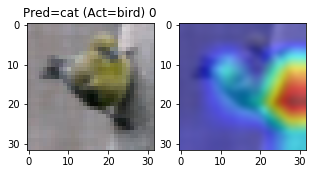

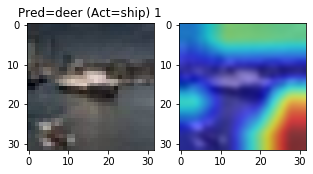

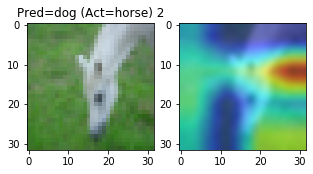

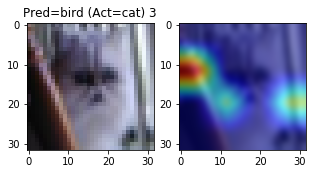

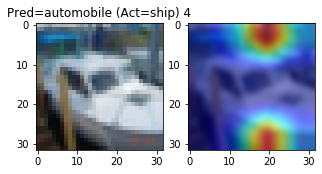

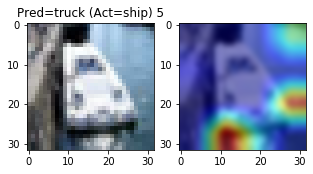

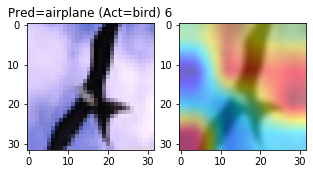

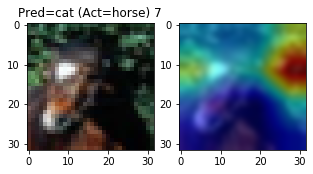

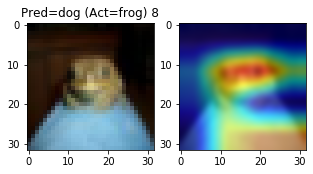

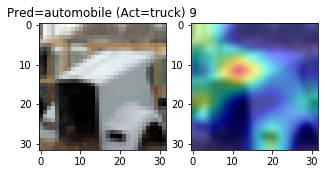

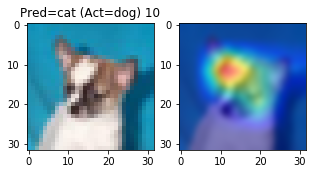

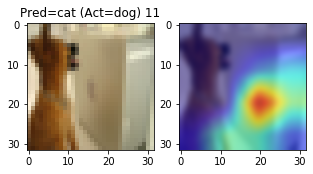

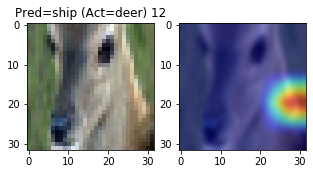

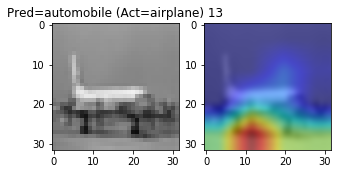

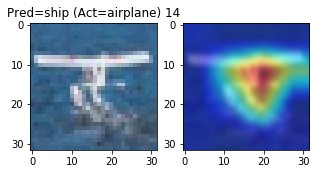

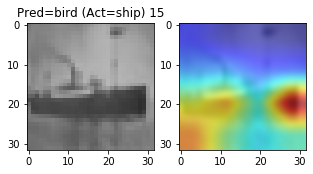

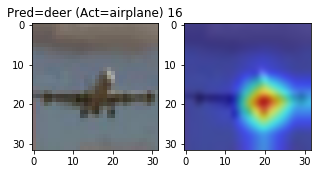

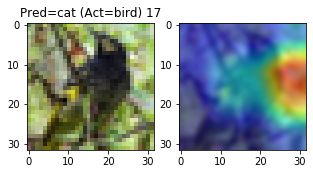

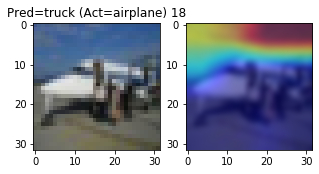

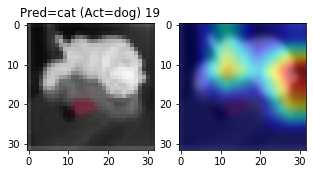

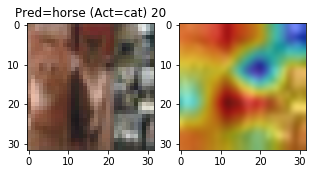

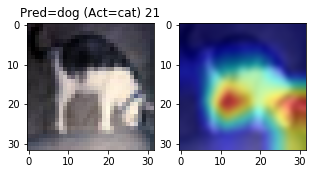

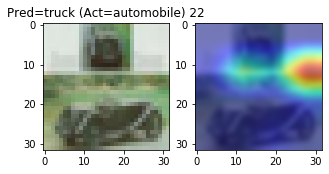

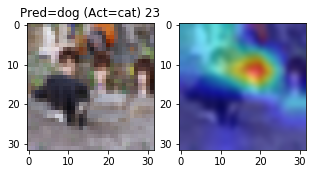

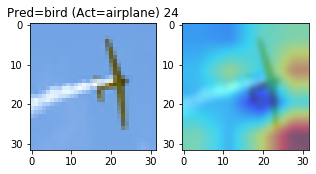

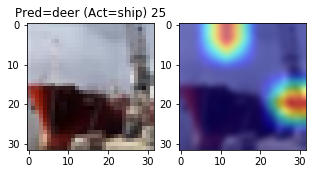

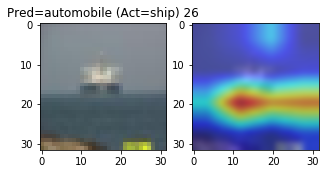

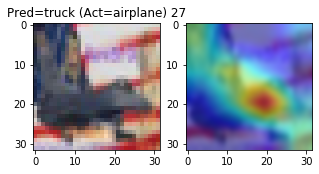

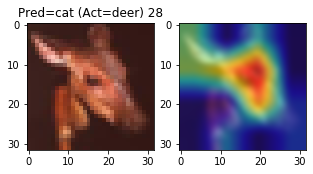

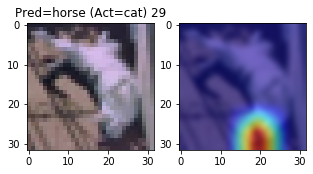

In [25]:
# plotdata.PlotData.plotmisclassifiedimages(dataiterator=dataiterator,model=model,classes=classes,
#                                           batch_size=batch_size,dogradcam=True,device=device)


classified, misclassified = train.TrainModel.getinferredimagesfromdataset(dataiterator=dataiterator, model=model,
                                                                          classes=classes, batch_size=batch_size,
                                                                          number=30)

# print(model)

print(len(classified))
print(len(misclassified))


print("Gradcam of misclassified images for Layer 34, Conv2d, Output Shape = 8")

plotdata.PlotData.plotinferredimagesfromdataset(misclassified, model, device, classes,"misclassifed"
                                                ,size=(5,20),layerNo=34)

Gradcam of correct classified images for Layer 34, Conv2d, Output Shape = 8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


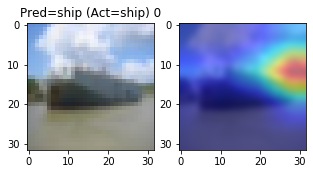

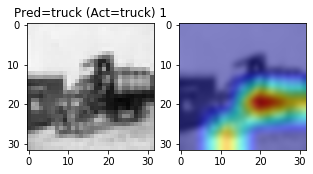

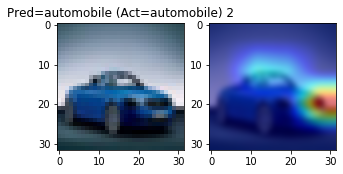

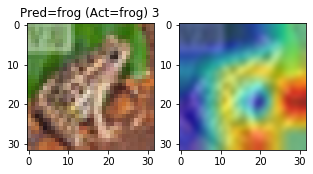

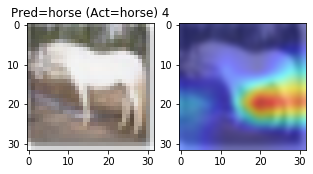

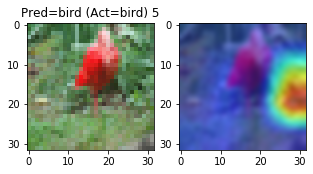

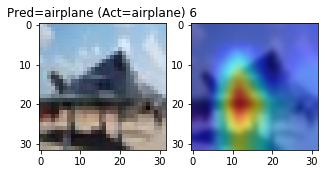

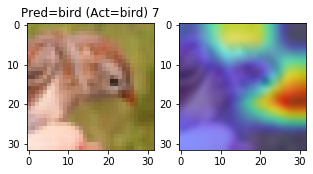

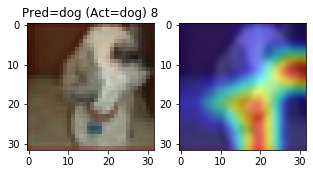

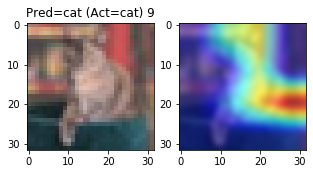

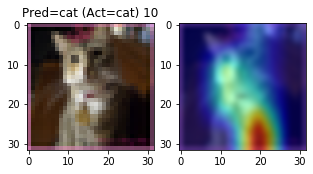

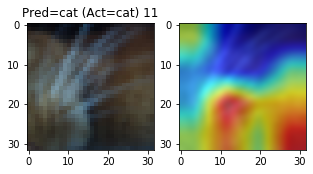

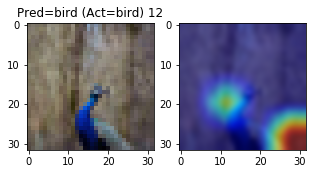

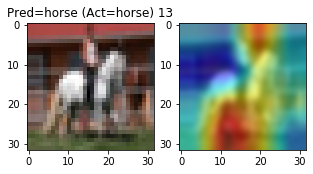

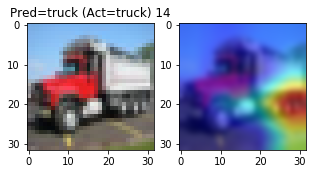

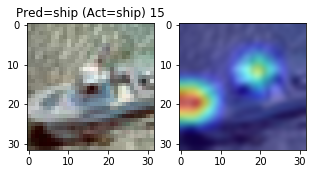

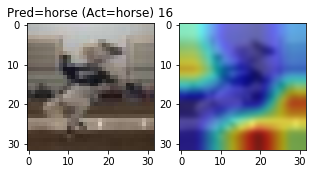

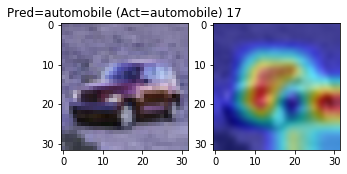

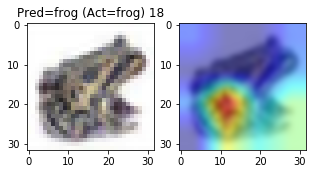

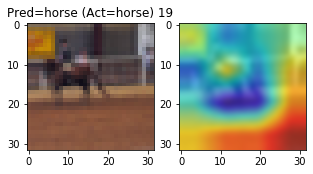

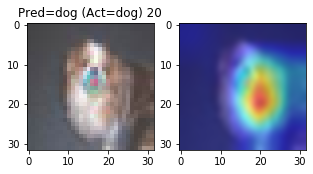

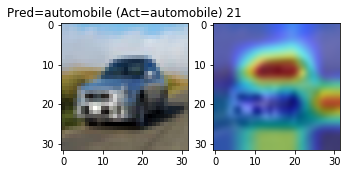

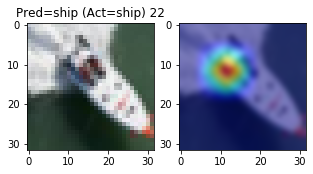

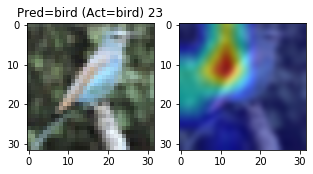

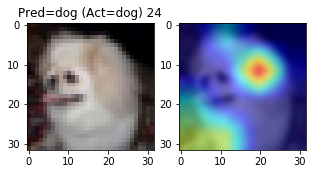

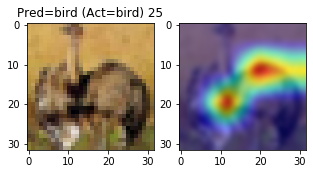

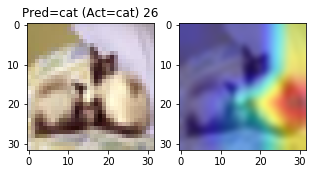

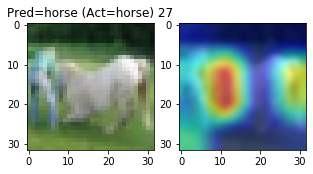

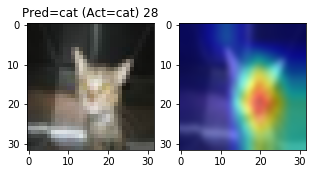

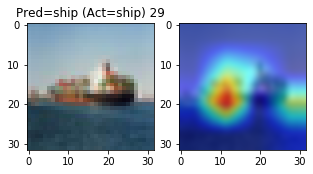

In [26]:
print("Gradcam of correct classified images for Layer 34, Conv2d, Output Shape = 8")

plotdata.PlotData.plotinferredimagesfromdataset(classified, model, device, classes,"correct"
                                                ,size=(5,20),layerNo=34)

In [27]:
utils.Utils.showaccuracyacrossclasses(class_correct=class_correct,class_total=class_total)

Test Accuracy of airplane: 85% (6787/7896)
Test Accuracy of automobile: 93% (7481/8034)
Test Accuracy of  bird: 77% (6164/7999)
Test Accuracy of   cat: 68% (5367/7815)
Test Accuracy of  deer: 80% (6374/7967)
Test Accuracy of   dog: 76% (6081/7911)
Test Accuracy of  frog: 88% (7051/7927)
Test Accuracy of horse: 87% (6846/7837)
Test Accuracy of  ship: 90% (7129/7843)
Test Accuracy of truck: 89% (6945/7771)

Test Accuracy (Overall): 83% (66225/79000)


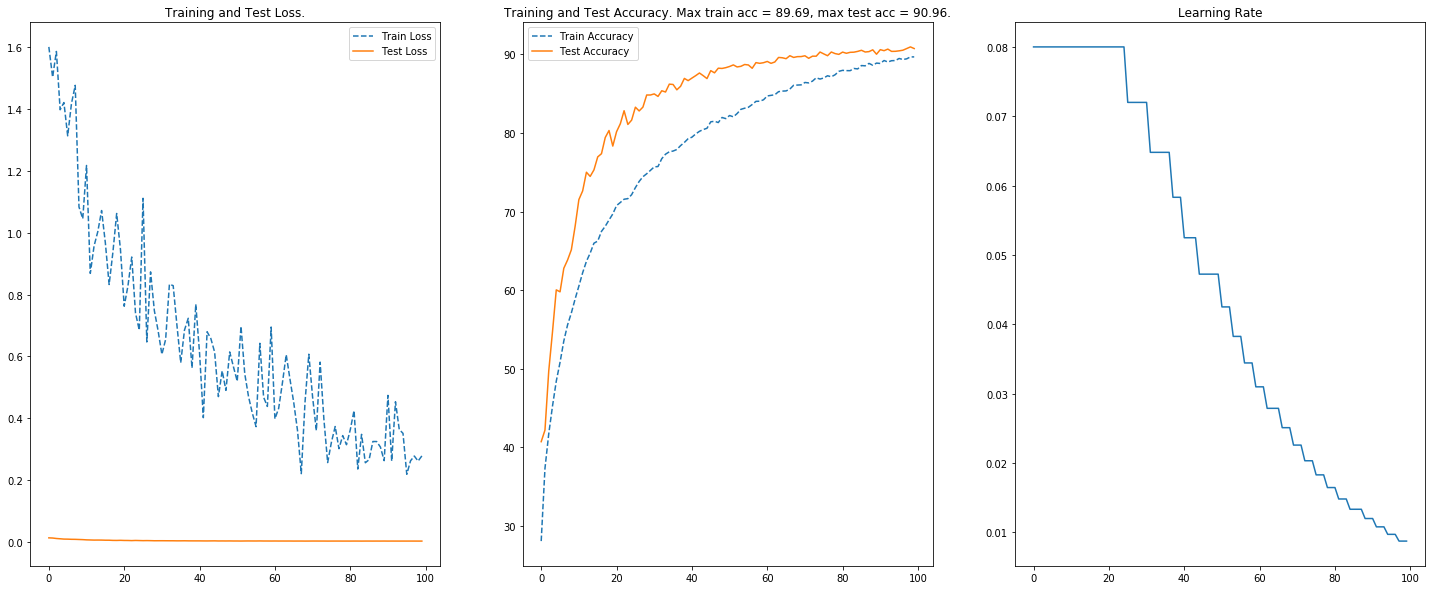

In [28]:
plotdata.PlotData.plottesttraingraph(train_losses=train_losses,train_acc=train_acc,test_losses=test_losses,
                                     test_acc=test_acc,lr_data=lr_data, plotonsamegraph=True,epochs=epoch,doProcessArray=False)

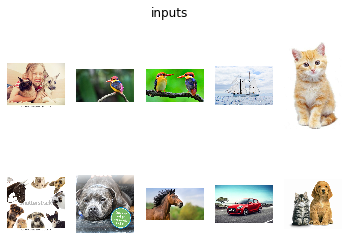

In [29]:
# from src.utils.modelutils import subplot
image_paths = glob.glob('./images/testimages/*.*')
images = list(map(lambda x: Image.open(x), image_paths))
subplot(images, title='inputs', nrows=2, ncols=5)

In [30]:
import torchvision

inputs = [torchvision.transforms.Compose([torchvision.transforms.Resize((32, 32)), torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])(
    x).unsqueeze(0) for x in images]  # add 1 dim for batch
inputs = [i.to(device) for i in inputs]

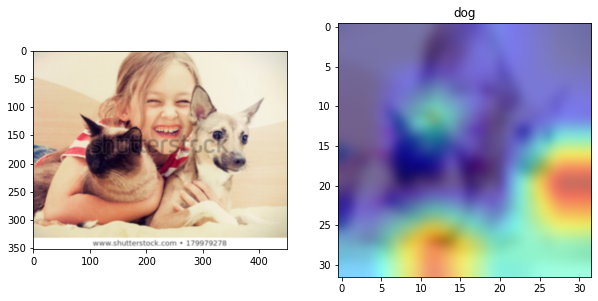

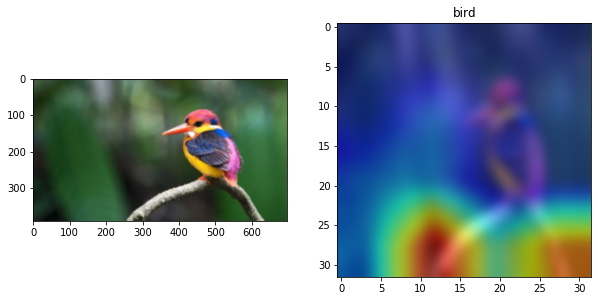

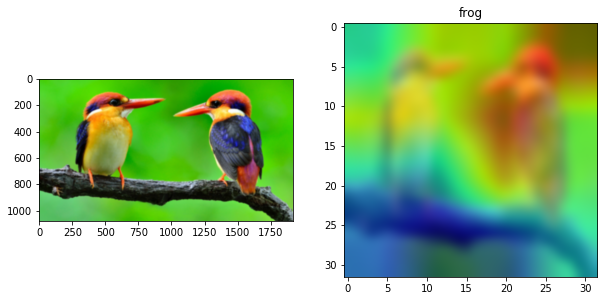

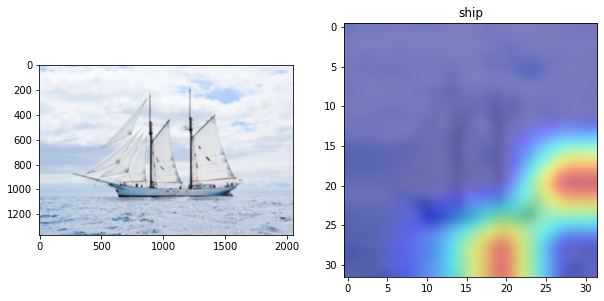

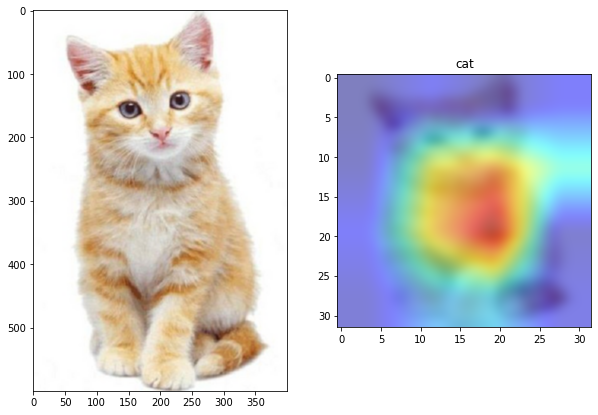

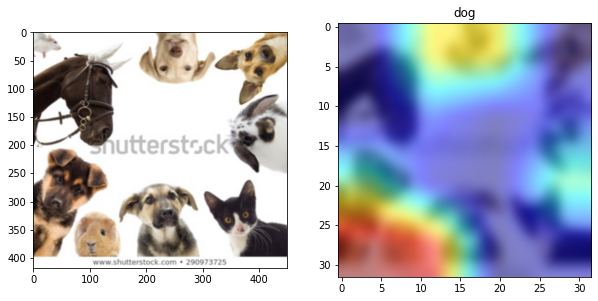

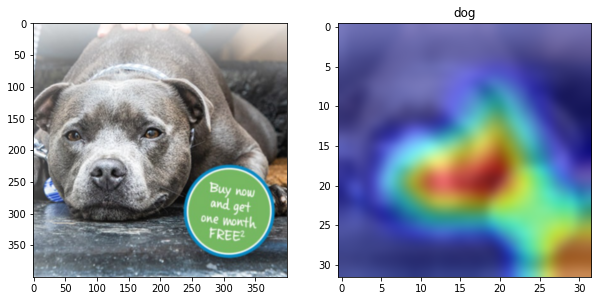

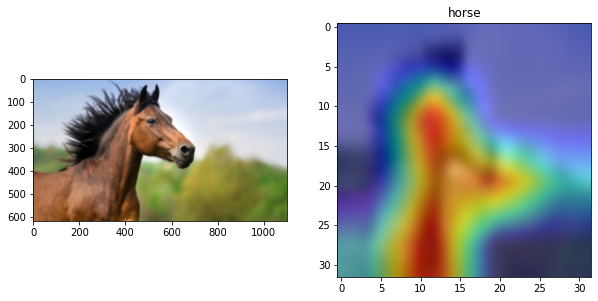

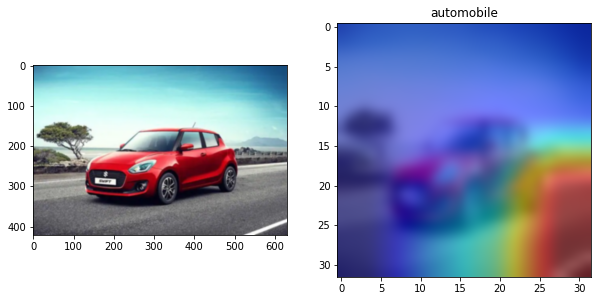

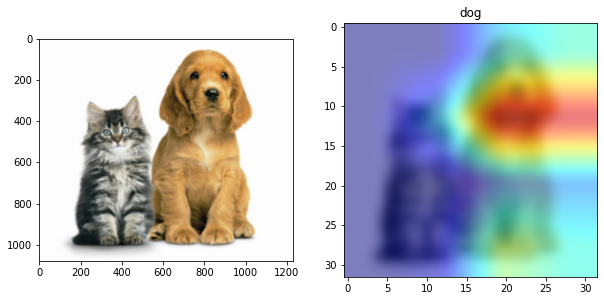

In [31]:
from src.visualization.gradcam.gradcam import GradCam
from src.visualization.gradcam import gradcamhelper

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

loc = 0

for input in inputs:  
    fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 25))   
    axes[0].imshow(images[loc], cmap="gray", interpolation='bicubic') 
    
    gradcamimage,prediction = gradcamhelper.dogradcam(model=model,image=input,device=device,classes=classes
                                                      ,layerNo=34)
    tensor = gradcamimage[0].squeeze()
    tensor = tensor.permute(1, 2, 0)
    img = tensor.cpu().numpy()
    axes[1].set_title(prediction["prediction"])    
    axes[1].imshow(img, cmap="gray", interpolation='bicubic')
    loc += 1

In [32]:
torch.cuda.empty_cache()

test_dataset = None
train_dataset = None
test_loader = None
train_loader = None

import gc
gc.collect()

43061